CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Some stuff to make utils-function work
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image
%load_ext autoreload
%autoreload 2

# Jupyter-specific
%matplotlib inline

Some parameters

In [2]:
data_dir = pathlib.Path('/mnt/sdb/kvasir-dataset-v2/')

config = {
    "data_dir": data_dir,
    "cache_dir": "./cache",
    "MODEL": 'cnn',
    "DS_INFO": 'complete',
    "resample": False,
    "neg_class": ['polyp'],
    "NUM_EPOCHS": 100,
    "BATCH_SIZE": 64,
    "IMG_SIZE": (32, 32, 3),
    "outcast": None,
    "verbosity": 1
    }

model_name = '{}x{}x{}_{}_{}'.format(config["NUM_EPOCHS"], config["BATCH_SIZE"], 
                                     config["IMG_SIZE"][1], config["DS_INFO"], config["MODEL"])

Create training, testing and validation dataset from utils/data_prep.py

In [3]:
train_ds, test_ds, val_ds, params = create_dataset(config)

Directories:  ['esophagitis' 'normal-pylorus' 'ulcerative-colitis' 'normal-cecum'
 'normal-z-line' 'polyps' 'dyed-resection-margins' 'dyed-lifted-polyps']

esophagitis       : 1000
normal-pylorus    : 1000
ulcerative-colitis: 1000
normal-cecum      : 1000
normal-z-line     : 1000
polyps            : 1000
dyed-resection-margins: 1000
dyed-lifted-polyps: 1000

Total number of images: 8000, in 8 classes
Dataset.list_files:  /mnt/sdb/kvasir-dataset-v2/*/*.*g 

[4 3 2 7 4 3 1 6 0 0]
[0 5 6 5 2 1 4 7 7 5]
[1 0 6 4 4 0 2 5 1 2]
[1 7 0 6 6 0 2 4 5 5]
[3 3 6 0 4 7 0 6 6 2]
[7 1 4 0 6 2 7 2 7 2]
[0 4 5 3 1 3 0 0 3 0]
[1 1 6 2 1 1 5 4 5 3]
[4 5 2 1 1 0 6 1 1 0]
[5 3 0 6 2 7 2 3 6 3]

Full dataset sample size:         8000
Train dataset sample size:        5600
Test dataset sample size:         1200
Validation dataset sample size:   1200


## Training
### Normal CNN
See: https://www.tensorflow.org/tutorials/images/cnn  
learningRateScheduler: https://github.com/lambdal/TensorFlow2-tutorial/tree/master/01-basic-image-classification  
model from: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/  

In [4]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler

Create the model

In [5]:
cnn_model = models.Sequential()

cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=config["IMG_SIZE"]))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.4))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(params["NUM_CLASSES"], activation='softmax'))

In [6]:
if config["verbosity"] > 0:
    cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        1

In [7]:
BASE_LEARNING_RATE = 0.1
LR_SCHEDULE = [(0.1, 15), (0.01, 90)]

def schedule(epoch):
    initial_learning_rate = BASE_LEARNING_RATE
    learning_rate = initial_learning_rate
    for mult, start_epoch in LR_SCHEDULE:
        if epoch >= start_epoch:
            learning_rate = initial_learning_rate * mult
        else:
            break
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

Compile and train the model

In [8]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir='./logs/tensorboard/{}'.format(model_name), update_freq='batch')
callbacks = [tensorboard_cb, LearningRateScheduler(schedule)]

In [9]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = params["train_size"] // config["BATCH_SIZE"],
        epochs = config["NUM_EPOCHS"],
        validation_data = test_ds,
        validation_steps = params["test_size"] // config["BATCH_SIZE"],
        validation_freq = 1,
        callbacks = callbacks)

Train for 87 steps, validate for 18 steps
Epoch 1/100
87/87 [==============================] - 47s 543ms/step - loss: 1.5808 - accuracy: 0.4758 - val_loss: 25.4145 - val_accuracy: 0.1450
Epoch 2/100
87/87 [==============================] - 1s 8ms/step - loss: 0.9918 - accuracy: 0.5711 - val_loss: 1.4329 - val_accuracy: 0.4748
Epoch 3/100
87/87 [==============================] - 1s 7ms/step - loss: 0.8677 - accuracy: 0.6142 - val_loss: 0.7685 - val_accuracy: 0.6163
Epoch 4/100
87/87 [==============================] - 1s 7ms/step - loss: 0.8258 - accuracy: 0.6325 - val_loss: 0.8333 - val_accuracy: 0.6259
Epoch 5/100
87/87 [==============================] - 1s 8ms/step - loss: 0.7875 - accuracy: 0.6422 - val_loss: 1.0828 - val_accuracy: 0.5790
Epoch 6/100
87/87 [==============================] - 1s 8ms/step - loss: 0.7494 - accuracy: 0.6545 - val_loss: 0.8528 - val_accuracy: 0.6042
Epoch 7/100
87/87 [==============================] - 1s 8ms/step - loss: 0.7579 - accuracy: 0.6670 - val_los

In [10]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [11]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=params["val_size"] // config["BATCH_SIZE"])

18/18 - 29s - loss: 0.3451 - accuracy: 0.8594


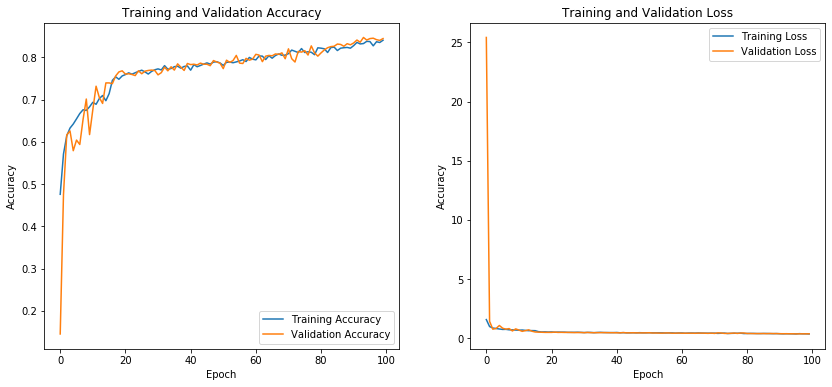

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(config["NUM_EPOCHS"])

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [13]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 esophagitis
0.0000 normal-pylorus
0.0000 ulcerative-colitis
0.0000 normal-cecum
0.0000 normal-z-line
0.0000 polyps
0.1779 dyed-resection-margins
0.8220 dyed-lifted-polyps

Label: dyed-lifted-polyps
Predicton: dyed-lifted-polyps


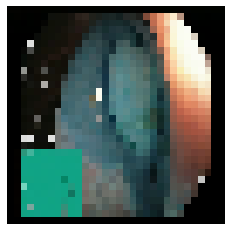

In [14]:
# Get a random image and label
rand = np.random.randint(0, config["BATCH_SIZE"])
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,params["class_names"][i]))

print ("\nLabel:", params["class_names"][label])
print ("Predicton:", params["class_names"][np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [15]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:<25} {:25}'.format('idx', 'label', 'pred'))
print ('---  {} {}'.format(25*'-', 25*'-'), end='')

for i, pred in enumerate(predictions):
    label = params["class_names"][labels[i]]
    prediction = params["class_names"][np.argmax(pred)]
    print ('\n{:3}  {:25} {:25}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label                     pred                     
---  ------------------------- -------------------------
  0  normal-z-line             esophagitis                Wrong
  1  dyed-lifted-polyps        dyed-resection-margins     Wrong
  2  esophagitis               esophagitis              
  3  normal-z-line             normal-z-line            
  4  ulcerative-colitis        ulcerative-colitis       
  5  normal-pylorus            normal-pylorus           
  6  esophagitis               esophagitis              
  7  normal-cecum              normal-cecum             
  8  dyed-lifted-polyps        dyed-lifted-polyps       
  9  normal-pylorus            normal-pylorus           
 10  dyed-resection-margins    dyed-resection-margins   
 11  polyps                    polyps                   
 12  normal-pylorus            normal-pylorus           
 13  polyps                    polyps                   
 14  dyed-lifted-polyps        dyed-lifted-polyps       
 15  normal-z-lin